# SCEL flight delay analysis - LATAM data scientist role - Geethasri Ramkumar

Install dependencies if needed. (optional)

Running the notebook causes a grid search to run towards the end which may take a few mins to finish. 

In [64]:
!pip install -r requirements.txt

Import all libs

In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score,roc_auc_score

from utilities import *
from ml_model import *

Load dataset

In [2]:
df = pd.read_csv('dataset_SCL.csv')
df.shape

C:\Users\Mahesh-PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(68206, 18)

Check if the dataset has any missing values. In this case, there is one record where Vlo-O is missing. Its the operation flight number and may not have any significane to flight delay prediction. Hence not dropping or imputing that missing value.

In [3]:
df.isna().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

Convert Fecha-I and Fecha-O to datetime in pandas for ease of use later.

In [4]:
df['Fecha-I'] = df['Fecha-I'].astype('datetime64')
df['Fecha-O'] = df['Fecha-O'].astype('datetime64')

# Question 1 - Summarized answers

(Detailed EDA below)

Data distribution:

a. Data with actual delays (> 0 minutes) constitute roughly two-third.

b. Date range spans entire year of 2017 with good representation from all months and days of week. This means the dataset contains data from all seasons.

c. Group Latam flights form the majority of flights from Santiago

d. International and national flights are also fairly evenly represented. National flights are little bit more, but that makes sense as in reality most airports will have more domestic traffic than international. 

Insights:

a. Buenos Aires is the most freuent destination overall from SCEL while Antofagasta is the favourite for Group Latam flights.

b. Percentage of data where operating airline code is different from scheduled airline code is 27.37 %. The most common is 'LAN' to 'LXP'

c. Destination city change - El Tepual airport was changed to Araucanía Airport (Temuco) 5 times in 2017. Balmaceda airport changed to El Teplual 4 times in 2017.

d. When there has been a delay, the average delay time for 2017 at SCEL is approx 15 minutes and for group latam is 13.6 minutes. Of all the delays, two-thirds caused by Group Latam flights. This might also be due to the fact that group LATAM operated nearly 60% of the flights from SCEL in 2017.

e. Occasionally there are delays that reach more than an hour although it is not a common occurence.

Take-aways:

a. Group LATAM operates majority of flights from SCEL and hence higher proportion of delays are due to Group LATAM. 

b. Airport is busy on all days of week with no significant preference to a particular day of week especially international flights.

c. Average no of flights per day during high season is 191.6. This is not so different from average no of flights during other parts of the year which is 184.7. So high season may not be that high after all.

d. Destination city change happens pretty rarely. May have happened because of unavoidable reasons.

e. Average delay, when there is a delay, is around 15 minutes, but median is only 8 minutes. Since there are outliers like 161 minute delays, average may be skewed. It would be useful to look at median and a value of 8 minutes could be considered acceptable for any airport. 

f. Group LATAM's median delay is also 8 minutes and having operated more flights than anyone else, the median delay is lower compared to many other airlines. Latam flights have done a decent job sticking to schedule as much as possible.

## EDA

# Origin city
Checking if there are other origin airports apart from SCEL. Looks like the dataset only contains data with SCEL as origin. 

In [5]:
print('Unique values present in Ori-I {}'.format(df['Ori-I'].unique()))
print('Unique values present in Ori-O {}'.format(df['Ori-O'].unique()))

Unique values present in Ori-I ['SCEL']
Unique values present in Ori-O ['SCEL']


# Dataset range

The range of the dataset is important info. It determines how much of an year was covered in the dataset and would have an influence on any inference made from the dataset. Since this is airlines data, it is important to have data from all seasons or months of an year. The dataset given contains data for a whole year (2017)

Range of dataset is from 2017-01-01 to 2018-01-01

Table below shows the count of data available for each month in 2017. All months are approx well represented in the dataset



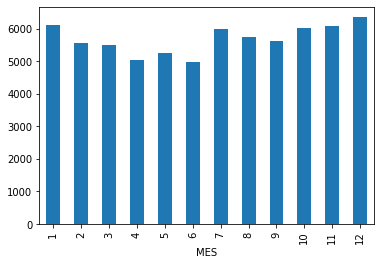

In [6]:
print('Range of dataset is from {} to {}\n'.format(str(df['Fecha-O'].min().date()),str(df['Fecha-O'].max().date())))
print('Table below shows the count of data available for each month in 2017. \
All months are approx well represented in the dataset\n')
df.groupby(['MES']).size().plot.bar()

# Emp-I & Emp-O

Plot the distribution of flights departing from SCEL. Latam airlines forms the majority followed by Sky airlines

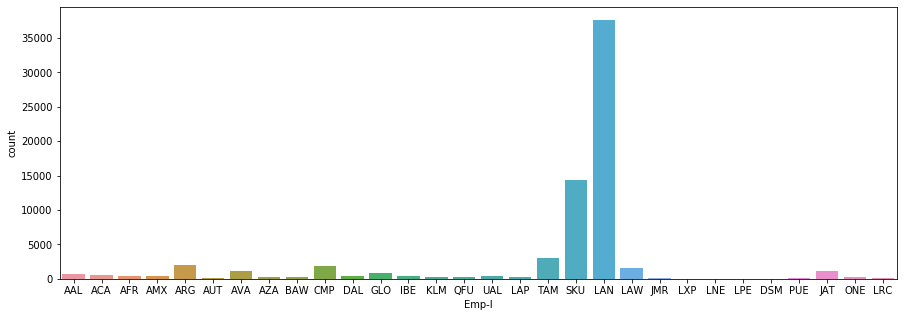

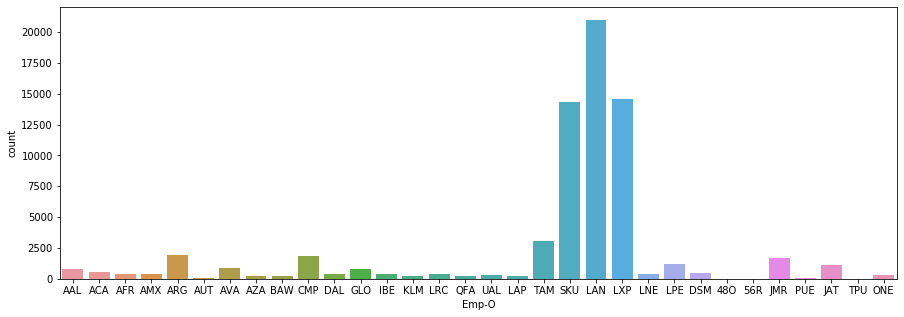

In [7]:
airline_cols = ['Emp-I','Emp-O']
for col in airline_cols:
    plt.figure(figsize=(15,5))
    sns.countplot(x=col,data=df)
    plt.show()

Proportion of flights operated by group Latam - nearly 60%

In [8]:
print('Proportion of flights operated by group Latam: {}'.format(round((df[df['OPERA']=='Grupo LATAM'].shape[0]/df.shape[0])*100,2)))

Proportion of flights operated by group Latam: 59.95


Check if scheduled airline and operating airline are always same. Approx 27% of the time, scheduled and operating airline code differ. 'LAN' to 'LXP' is most common accounting for more than half the change. Both are group Latam. 

In [9]:
df_changed = df[df['Emp-I']!=df['Emp-O']]
print('Percentage of data where operating airline code is different \
from scheduled airline code: {} %\n'.format(round((df_changed.shape[0]/df.shape[0])*100,2)))
print('Table below shows the no of times a particular airline code was changed to another while operating\n')
df_changed.groupby(['Emp-I','Emp-O']).size().reset_index(name='counts').sort_values('counts',ascending=False)

Percentage of data where operating airline code is different from scheduled airline code: 27.37 %

Table below shows the no of times a particular airline code was changed to another while operating



,Emp-I,Emp-O,counts
7,LAN,LXP,14549
10,LAW,JMR,1547
6,LAN,LPE,1210
4,LAN,DSM,491
5,LAN,LNE,373
2,AVA,LRC,265
11,QFU,QFA,195
9,LAW,56R,17
8,LAW,48O,10
0,ARG,AUT,5


# TIPOVUELO
Plot the distribution of International and National flights. National flights are slightly more than international flights but not highly imbalanced.

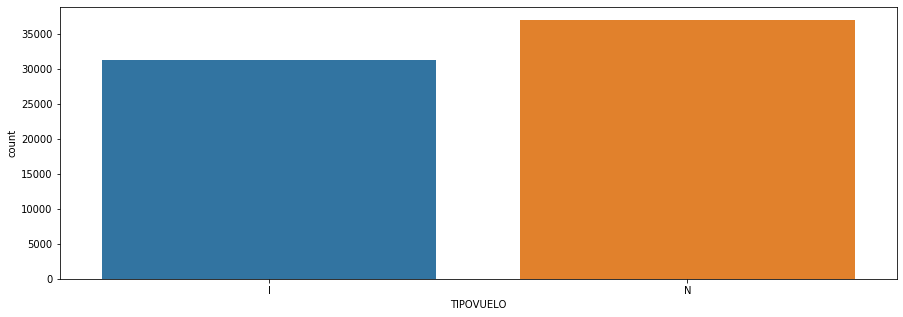

In [10]:
plt.figure(figsize=(15,5))
sns.countplot(x='TIPOVUELO',data=df)
plt.show()

# SIGLADES
Top destinations from Santiago. Buenos Aires is the most common accounting for 9.29%. While Antofagasta,Chile is the most frequent destination for Group Latam in 2017 from Santiago.

In [11]:
print('Top 5 destinations overall\n')
print(df['SIGLADES'].value_counts(normalize=True).mul(100).round(2).head(5))
print('\nTop 5 destinations for group LATAM\n')
print(df[df['OPERA']=='Grupo LATAM']['SIGLADES'].value_counts(normalize=True).mul(100).round(2).head(5))

Top 5 destinations overall

Buenos Aires    9.29
Antofagasta     8.48
Lima            7.73
Calama          7.54
Puerto Montt    6.39
Name: SIGLADES, dtype: float64

Top 5 destinations for group LATAM

Antofagasta     9.61
Calama          8.22
Lima            7.80
Buenos Aires    7.15
Puerto Montt    6.80
Name: SIGLADES, dtype: float64


# DIANOM
Overall distribution of day of week is pretty even with flights operating on almost everyday with Saturday being the lowest at 12% and Friday being the highest at 15%. International flights depart on all days of week approx the same but national flights depart less on Saturdays compared to other days of week (10.44%)

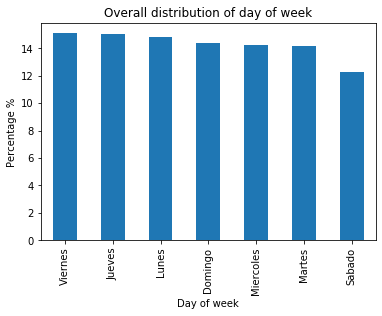

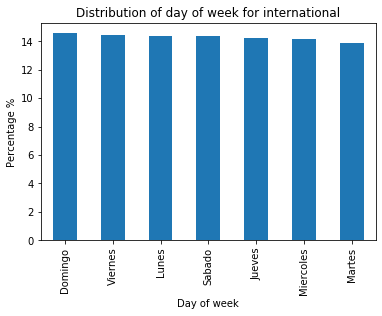

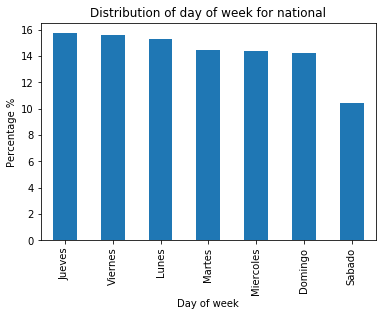

In [12]:
#print('Overall distribution of day of week\n')
day_week_overall = df['DIANOM'].value_counts(normalize=True).mul(100).round(2)
day_week_overall.plot.bar()
plt.title('Overall distribution of day of week')
plt.xlabel('Day of week')
plt.ylabel('Percentage %')
plt.show()

day_week_intnl = df[df['TIPOVUELO']=='I']['DIANOM'].value_counts(normalize=True).mul(100).round(2)
day_week_intnl.plot.bar()
plt.title('Distribution of day of week for international')
plt.xlabel('Day of week')
plt.ylabel('Percentage %')
plt.show()

day_week_ntnl = df[df['TIPOVUELO']=='N']['DIANOM'].value_counts(normalize=True).mul(100).round(2)
day_week_ntnl.plot.bar()
plt.title('Distribution of day of week for national')
plt.xlabel('Day of week')
plt.ylabel('Percentage %')
plt.show()

# DIA
Flight counts on each day of month is pretty evenly spread without any notable peaks or drops. The 31st day of a month has a lowe flight count but that is understandable since not all months have 31 days.

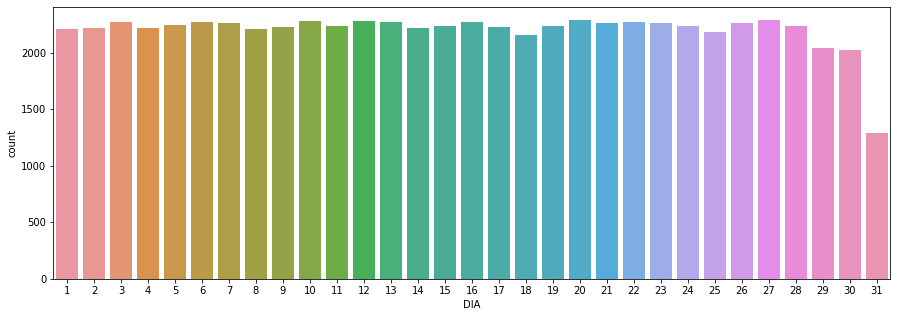

In [13]:
plt.figure(figsize=(15,5))
sns.countplot(x='DIA',data=df)
plt.show()

# Des-I & Des-O
Looking at whether destination airport were changed, the no of times this happened is very small (less than 0.1%). El Tepual airport was changed to Araucanía Airport (Temuco) 5 times in 2017.

In [14]:
df_changed = df[df['Des-I']!=df['Des-O']]
print('Percentage of data where scheduled destination code is different \
from operating destination code: {} %\n'.format(round((df_changed.shape[0]/df.shape[0])*100,2)))
print('Table below shows the no of times a particular destination airport was changed to another while operating\n')
df_changed.groupby(['Des-I','Des-O']).size().reset_index(name='counts').sort_values('counts',ascending=False)

Percentage of data where scheduled destination code is different from operating destination code: 0.04 %

Table below shows the no of times a particular destination airport was changed to another while operating



,Des-I,Des-O,counts
12,SCTE,SCQP,5
2,SABE,SAEZ,4
6,SCBA,SCTE,4
3,SAEZ,SABE,3
0,KIAH,KIAD,1
1,KJFK,KMIA,1
4,SARI,SBFI,1
5,SBGR,SBGL,1
7,SCCI,SCTE,1
8,SCFA,SCCF,1


# Delay in minutes
Calculate difference between scheduled and operating departure times. Approx one-third of the time the flights depart on time or even early. When there has been a delay, the average delay time for 2017 at SCEL is approx 15 minutes and for group latam is 13.6 minutes. Of all the delays, two-thirds caused by Group Latam flights.

In [15]:
df = FeatureUtil.calc_min_diff(df)
print('Proportion of no delays: {} %'.format(round((df[df['min_diff']<=0].shape[0]/df.shape[0])*100,2)))
print('Proportion of delays: {} %'.format(round((df[df['min_diff']>0].shape[0]/df.shape[0])*100,2)))

Proportion of no delays: 33.28 %
Proportion of delays: 66.72 %


Following figure shows the distribution of delay times

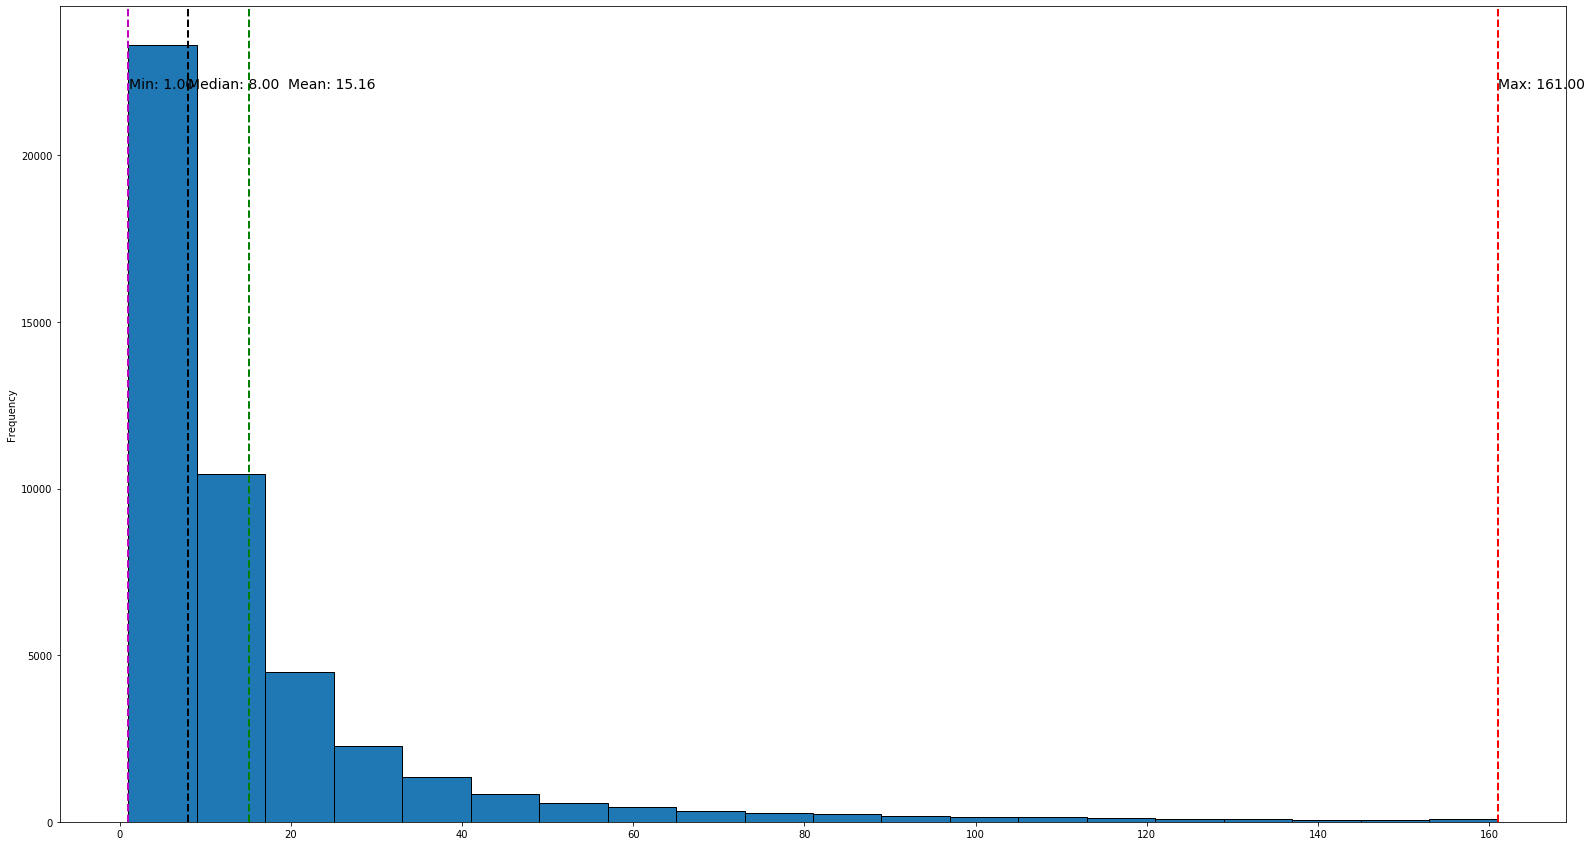

In [16]:
df_delay = df[df['min_diff']>0].reset_index(drop=True)
plt.figure(figsize=(27,15))
df_delay['min_diff'].plot.hist(stacked=True, bins=20,edgecolor='k')
plt.axvline(df_delay['min_diff'].mean(), color='g', linestyle='dashed', linewidth=2)
plt.axvline(df_delay['min_diff'].max(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(df_delay['min_diff'].min(), color='m', linestyle='dashed', linewidth=2)
plt.axvline(df_delay['min_diff'].median(), color='k', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_delay['min_diff'].mean()*1.3, max_ylim*0.9, 'Mean: {:.2f}'.format(df_delay['min_diff'].mean()),fontsize=14)
plt.text(df_delay['min_diff'].min()*1.1, max_ylim*0.9, 'Min: {:.2f}'.format(df_delay['min_diff'].min()),fontsize=14)
plt.text(df_delay['min_diff'].max()*1, max_ylim*0.9, 'Max: {:.2f}'.format(df_delay['min_diff'].max()),fontsize=14)
plt.text(df_delay['min_diff'].median()*1, max_ylim*0.9, 'Median: {:.2f}'.format(df_delay['min_diff'].median()),fontsize=14)

plt.show()

Proportion of delays by LATAM: 66.21 %


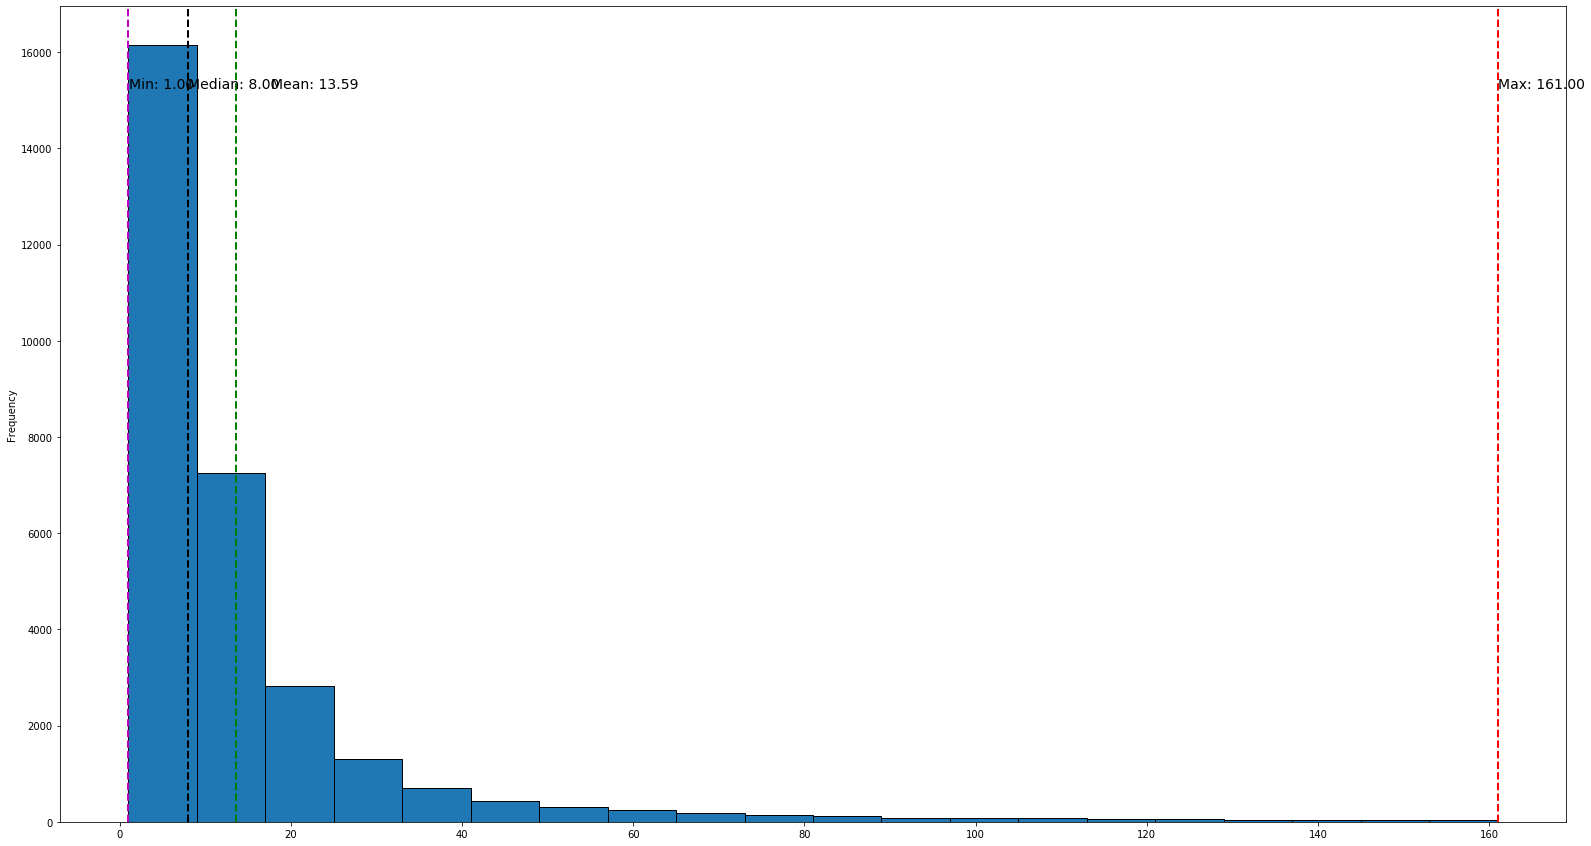

In [17]:
df_delay_latam = df[(df['min_diff']>0) & (df['OPERA']=='Grupo LATAM')].reset_index(drop=True)
print('Proportion of delays by LATAM: {} %'.format(round((df_delay_latam.shape[0]/df_delay.shape[0])*100,2)))
plt.figure(figsize=(27,15))
df_delay_latam['min_diff'].plot.hist(stacked=True, bins=20,edgecolor='k')
plt.axvline(df_delay_latam['min_diff'].mean(), color='g', linestyle='dashed', linewidth=2)
plt.axvline(df_delay_latam['min_diff'].max(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(df_delay_latam['min_diff'].min(), color='m', linestyle='dashed', linewidth=2)
plt.axvline(df_delay_latam['min_diff'].median(), color='k', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_delay_latam['min_diff'].mean()*1.3, max_ylim*0.9, 'Mean: {:.2f}'.format(df_delay_latam['min_diff'].mean()),fontsize=14)
plt.text(df_delay_latam['min_diff'].min()*1.1, max_ylim*0.9, 'Min: {:.2f}'.format(df_delay_latam['min_diff'].min()),fontsize=14)
plt.text(df_delay_latam['min_diff'].max()*1, max_ylim*0.9, 'Max: {:.2f}'.format(df_delay_latam['min_diff'].max()),fontsize=14)
plt.text(df_delay_latam['min_diff'].median()*1, max_ylim*0.9, 'Median: {:.2f}'.format(df_delay_latam['min_diff'].median()),fontsize=14)
plt.show()

Following figure shows that Group Latam flights have comparatively better median delay in minutes even though, they have operated more flights than anyone else. 

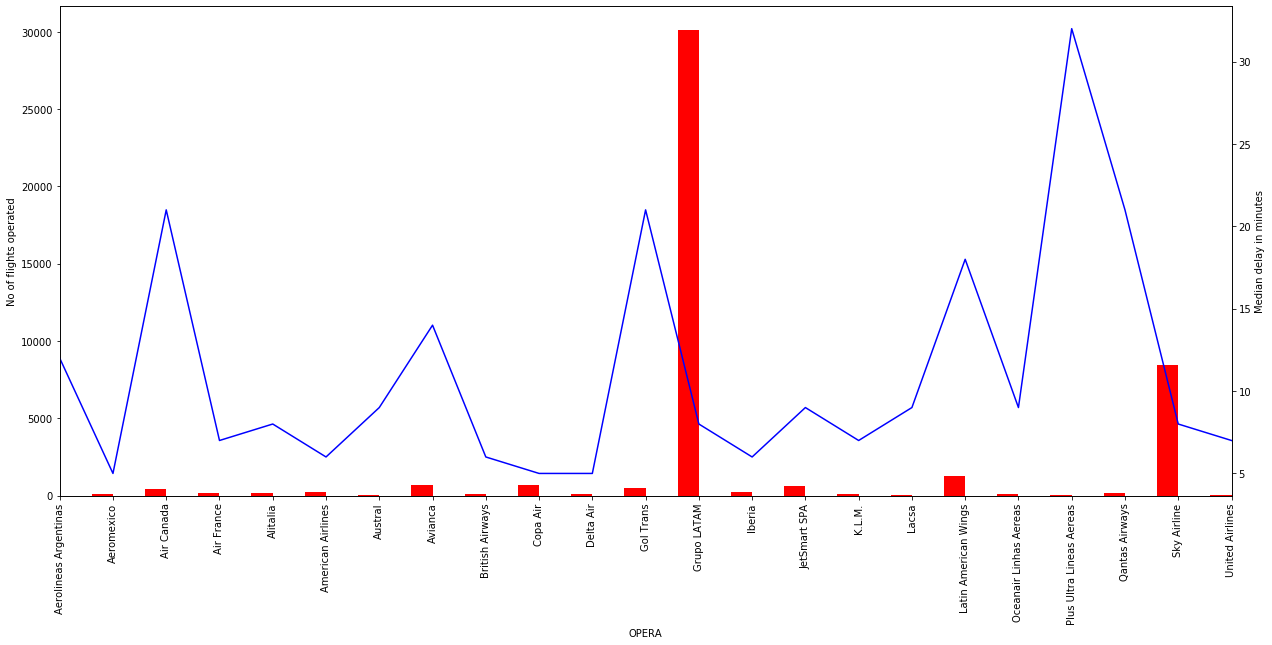

In [18]:
df_delay_airlines = df_delay.groupby(['OPERA'])['min_diff'].agg(['median','count'])

fig = plt.figure(figsize=(21,9)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.4
df_delay_airlines['count'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
df_delay_airlines['median'].plot(color='blue', ax=ax2)
ax.set_ylabel('No of flights operated')
ax2.set_ylabel('Median delay in minutes')
plt.show()

# High season

In [19]:
df = FeatureUtil.calc_high_season(df)
df.high_season.value_counts(normalize=True).mul(100).round(2)

0    67.7
1    32.3
Name: high_season, dtype: float64

High season contains 115 days. So calculating average no of flights per day during high season. It is 191.6 flights per day. This is not so different from average no of flights during other parts of the year which is 184.7. So high season may not be that high after all. 

In [20]:
print('Average no of flights during high season: {}'.format(round((df[df.high_season == 1].shape[0]/115),1)))
print('Average no of flights outside of high season: {}'.format(round((df[df.high_season == 0].shape[0]/250),1)))

Average no of flights during high season: 191.6
Average no of flights outside of high season: 184.7


#  Question 2
'min_diff' & 'high_season' have already been created. Next 'delay_15' and 'period_day' will be created and dumped as a csv with filename 'synthetic_features.csv'

In [21]:
df = FeatureUtil.calc_delay15(df) #delay_15 column
df['period_day'] = df['Fecha-I'].dt.hour.apply(FeatureUtil.calc_period_day) #period_day column

Dump the dataframe with sythetic features as csv

In [22]:
#df.to_csv('synthetic_features.csv')

# Question 3

# Delay rate analysis

# Assuming delays of over 15 mins as real delays and hence basing the delay rate analysis study on delay_15 column. 

# Plots of SIGLADES and OPERA

Plotting the delay rate with respect to multiple columns in question. The delay rates are plotted in decreasing order. First looking at destination city and airline.

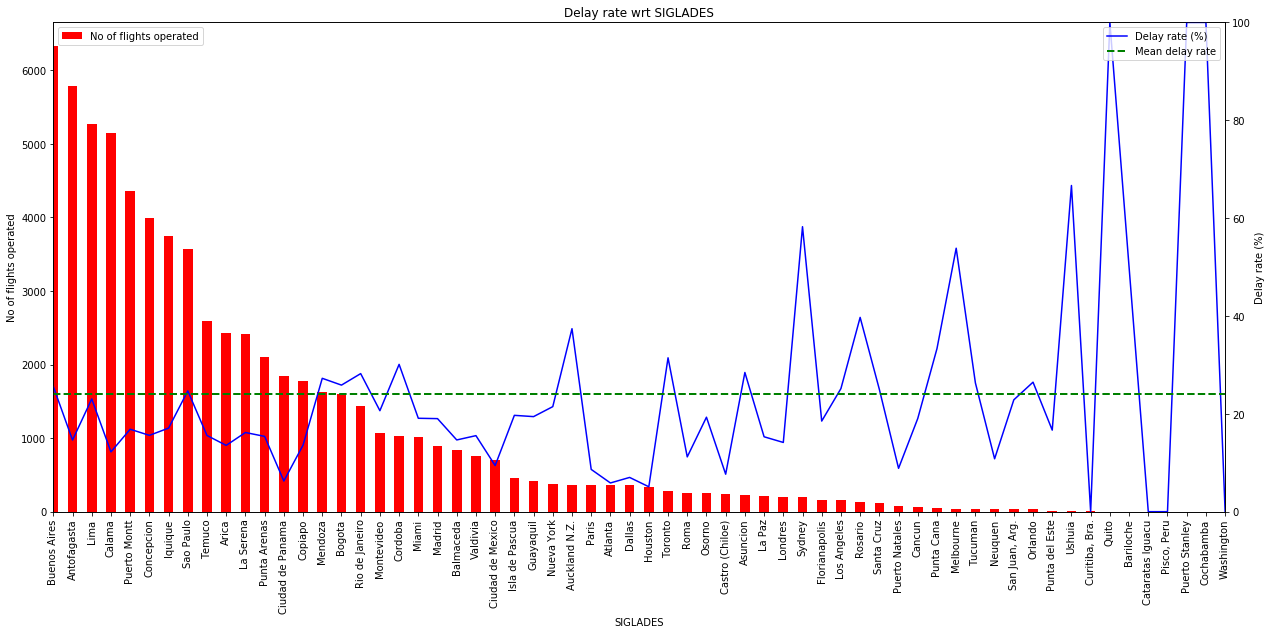

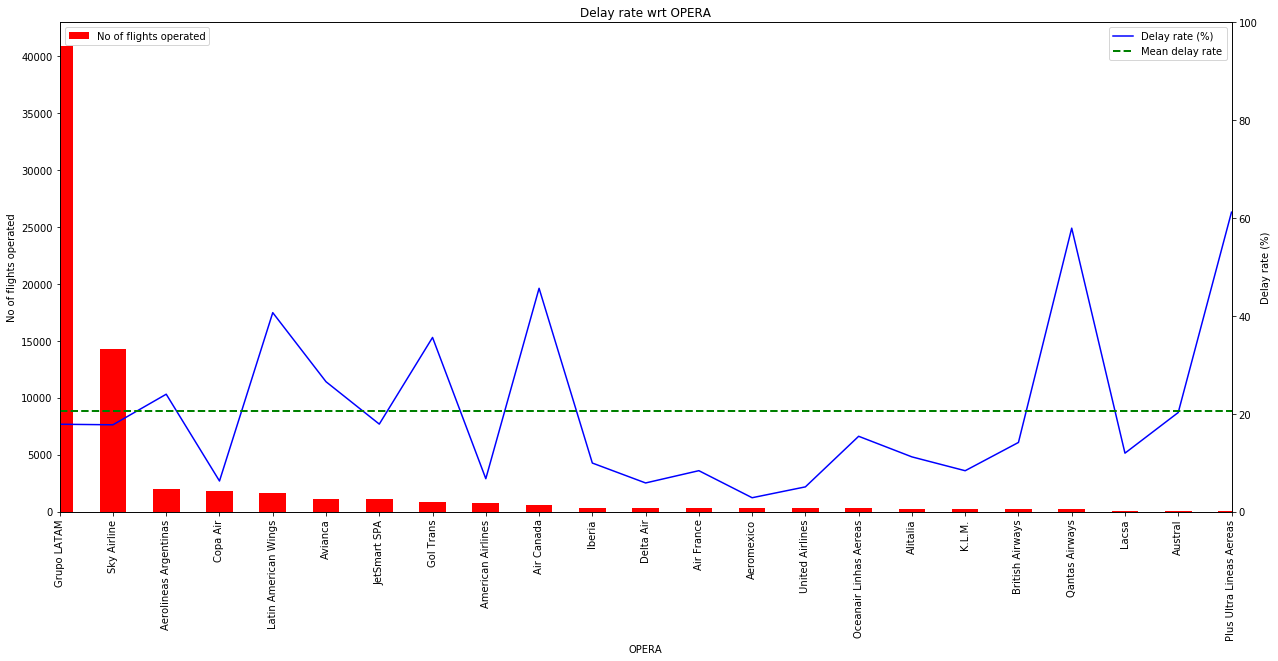

In [23]:
cols = ['SIGLADES','OPERA']
for col in cols:
    data = FeatureUtil.calc_delay_rate(df,col).sort_values('count', ascending=False)
    fig = PlotUtil.plot_bar_delay_rate(data,col,'count')
    plt.show()

# Plots of SIGLADES and OPERA with a filter of at least 1000 flights.

We see higher delay rates as the no of flights operated reduces. To make sure this is true, we also plot the graph but with a filter of greater than 1000 flights. This would give us a better picture of the delay rate because higher delay rates caused by destination cities and airlines that are not so frequent can skew the overall delay rate and mislead us. The plots below show that the delay rate with a filter of at least 1000 flights. It is less erratic than the ones that have less than 1000 flights recorded. But it does vary according to destination city and airline and moreover the less frequent the destination city or airline is at Santiago, the better the chances of having a delay.

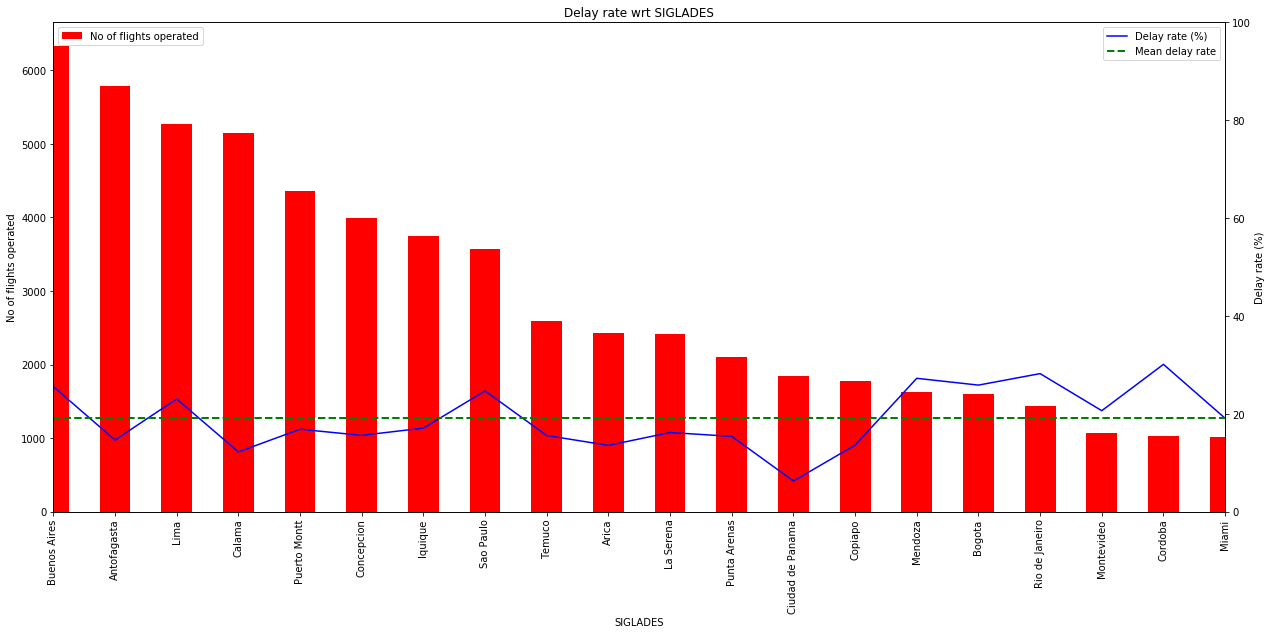

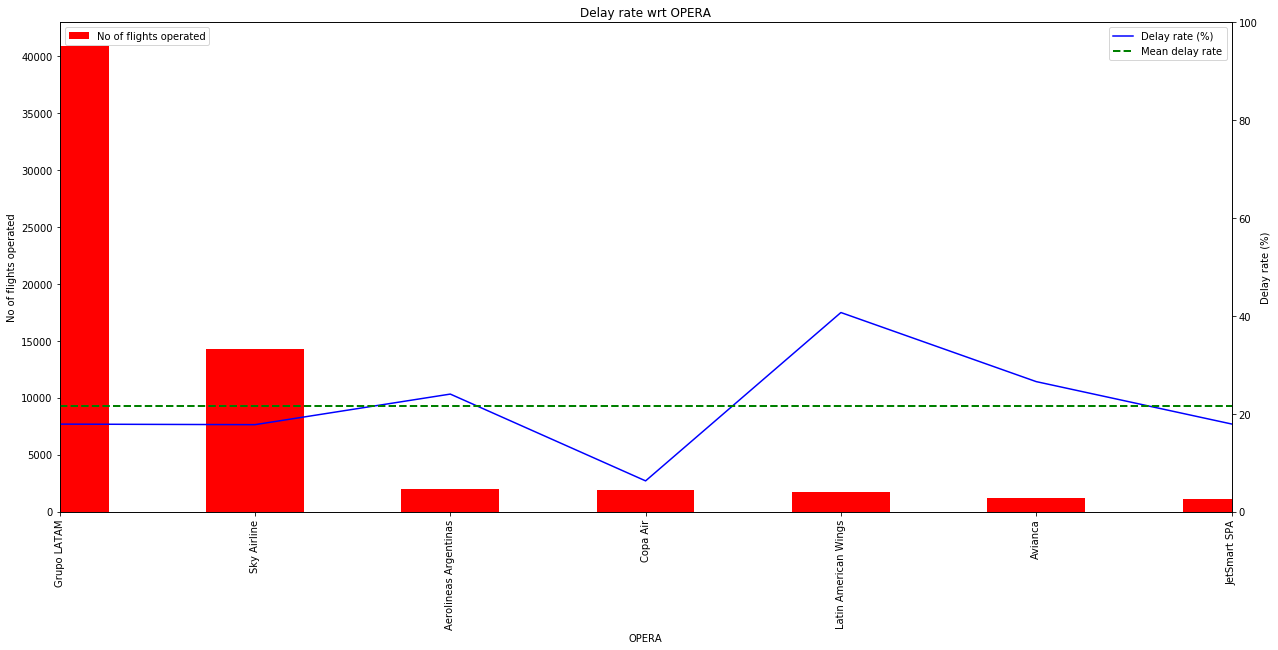

In [24]:
cols = ['SIGLADES','OPERA']
for col in cols:
    data = FeatureUtil.calc_delay_rate(df,col).sort_values('count', ascending=False)
    data = data[data['count']>1000] #filter for greater than 1000 flights
    fig = PlotUtil.plot_bar_delay_rate(data,col,'count')
    plt.show()

# Plots of 'MES','DIANOM','high_season','TIPOVUELO','DIA'

For month of year, day of week, high season, and type of flight, the variation of delay rate is not that pronounced. There are a few highs and lows but no significant peaks or drops. This can be seen from the plots where the delay rate line follows closely the mean delay rate line. 

For day of the month, dates between 11th and 17th of a month seems to have higher than average delay rate compared to rest of the days. 

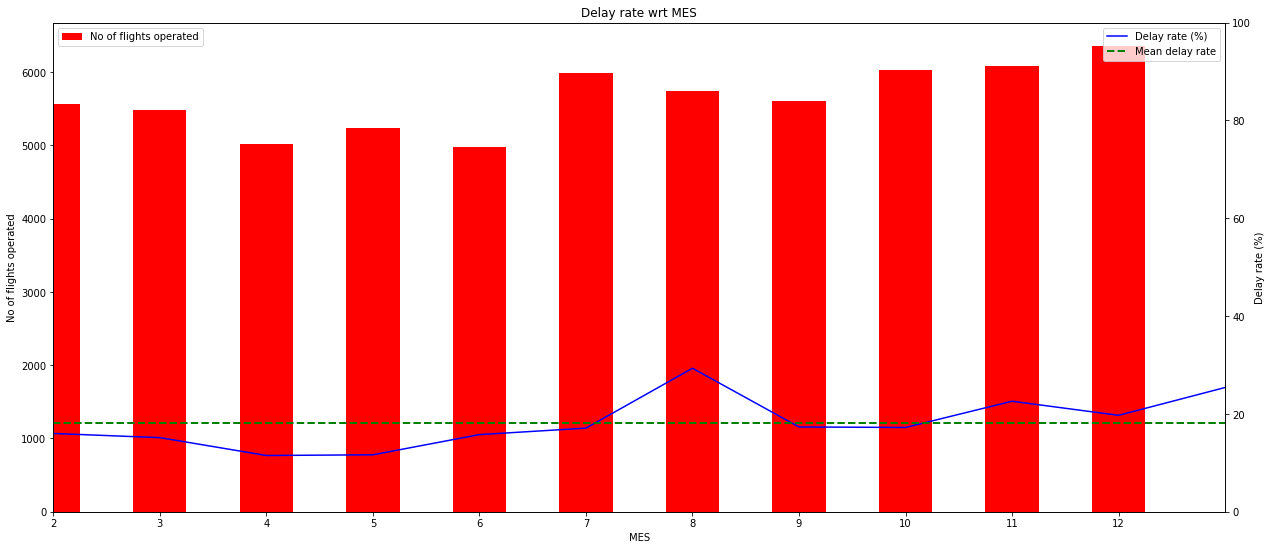

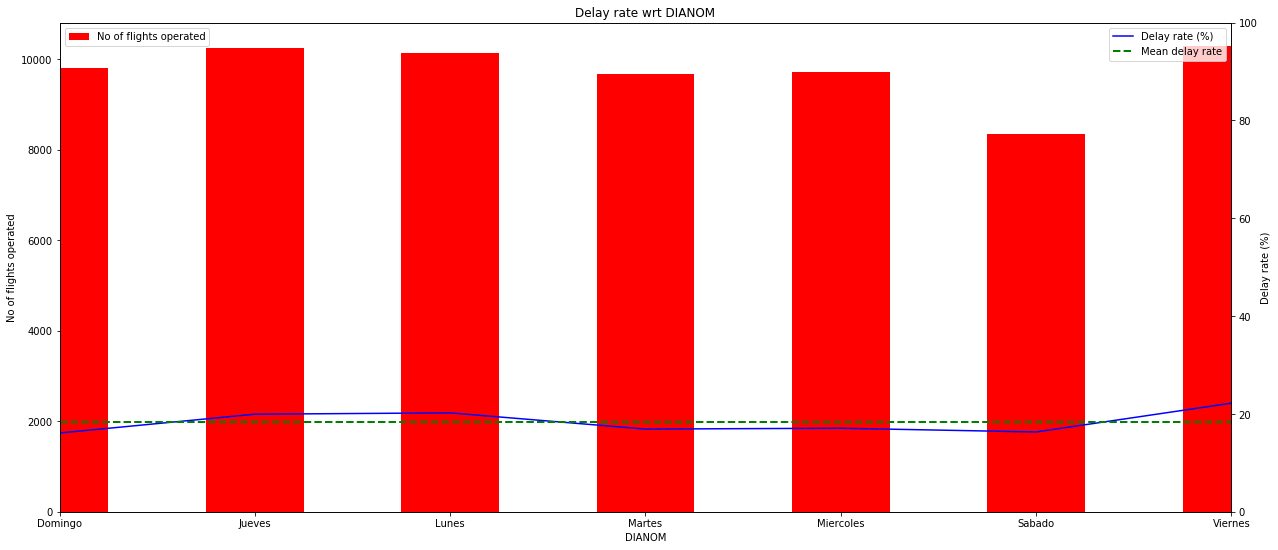

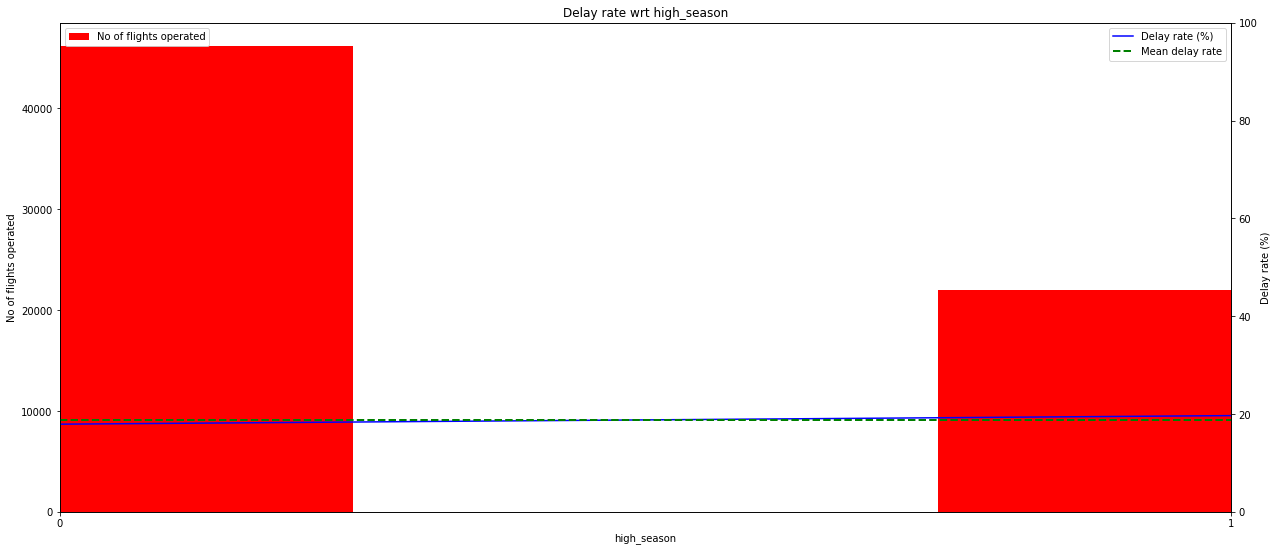

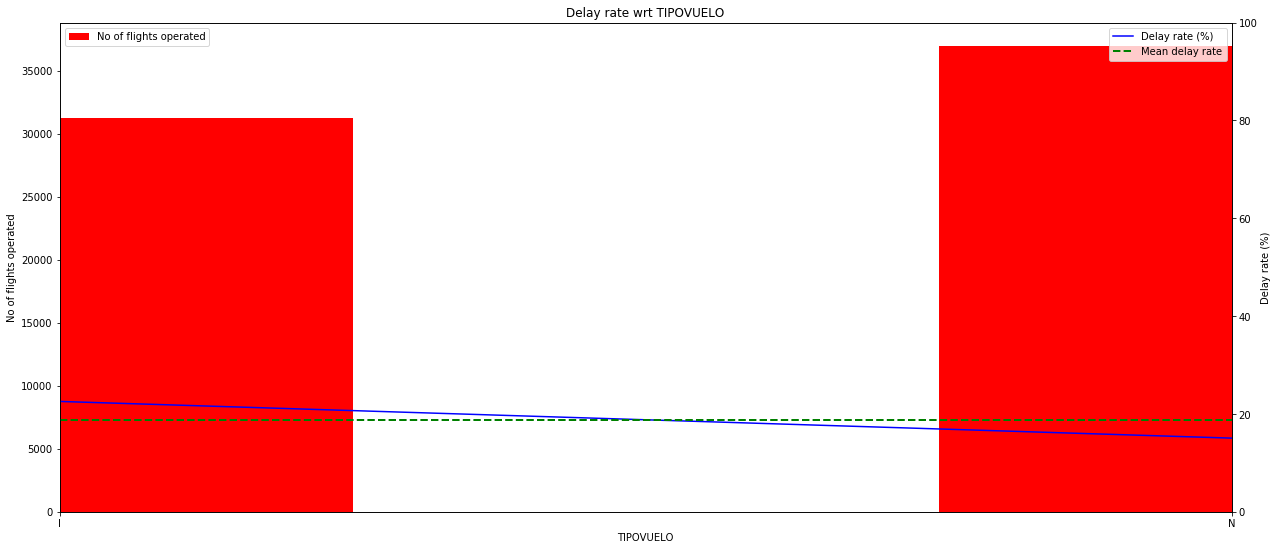

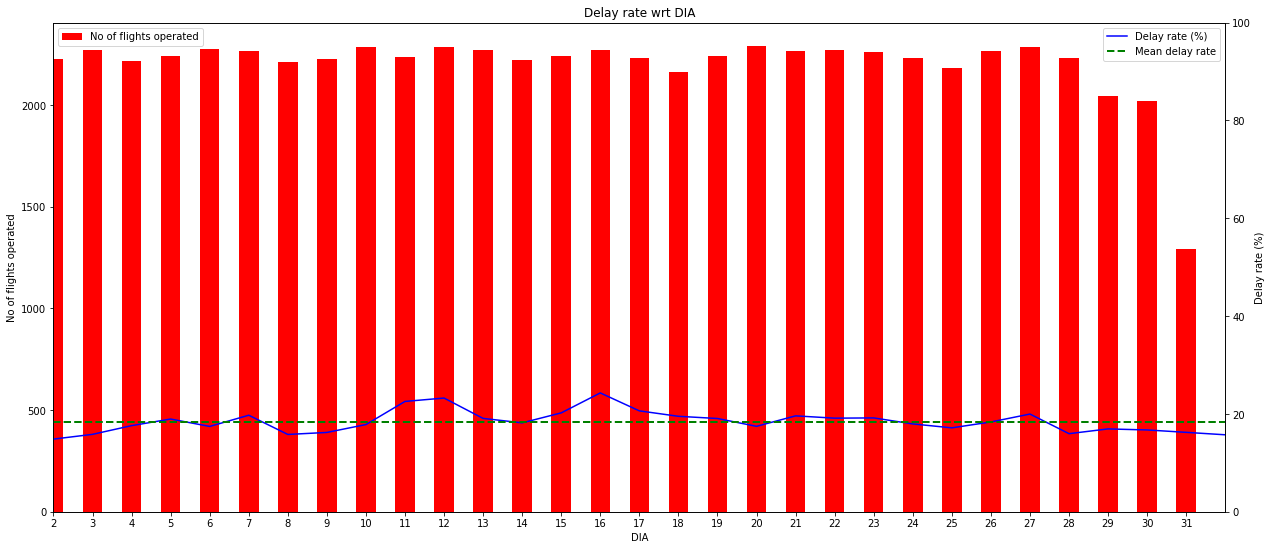

In [25]:
cols = ['MES','DIANOM','high_season','TIPOVUELO','DIA']

for col in cols:
    data = FeatureUtil.calc_delay_rate(df,col)
    fig = PlotUtil.plot_bar_delay_rate(data,col,'count')
    plt.show()

# Plots with hour of day

Interstingly the hour of day gives a good picture of delays as well. Below plot shows that early hours between 1am to 5am the delay rate is comparatively lower compared to rest of the day. This could be because of less traffic at these times.  

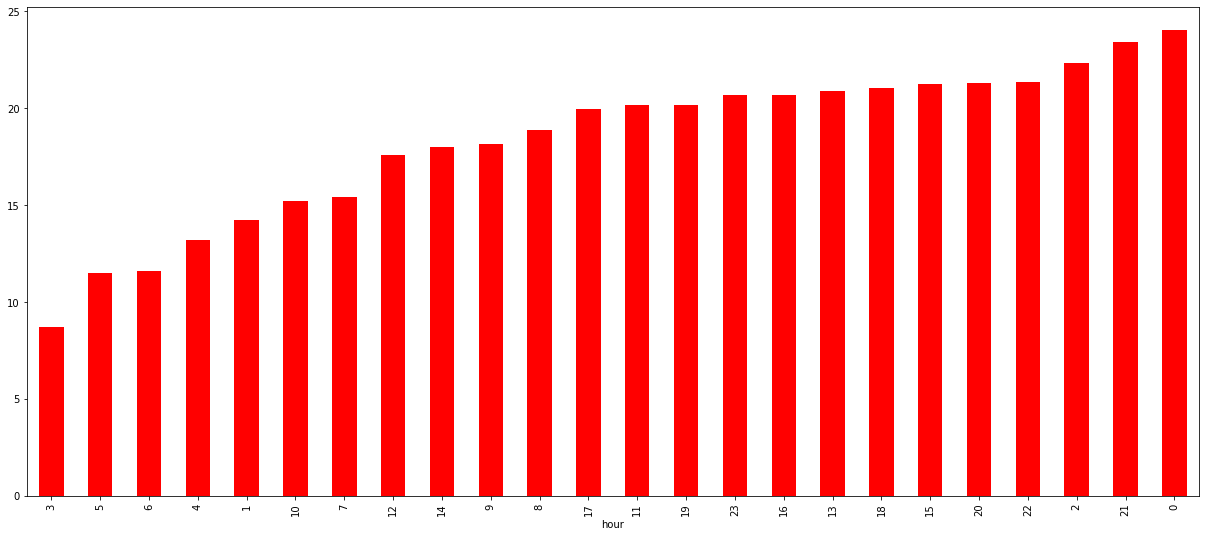

In [26]:
df['hour'] = df['Fecha-I'].dt.hour.astype(str)
col = 'hour'
data = FeatureUtil.calc_delay_rate(df,col).sort_values('delay_rate')
plt.figure(figsize=(21,9))
data['delay_rate'].plot(kind='bar', color='red',label='No of flights operated')

# Which variables would be useful?
a. Destination city, airline and period_day or hour of day would be useful in determining the delays since preliminary plots show some variance wrt to each of their values. But grouping the less common desination cities and airline into one group named 'Other' would be beneficial.

b. Month of year would also be useful since some months have shown to have some peaks and drops. Theoretically, people prefer to travel during certain months to certain locations, especially the popular locations. This could cause delays. 

c. The other variables like type of flight, day of week, high_season did not have a lot of difference in terms of delay rate but would still have them part of the model because practically there are a lot of passengers who love to travel during high seasons or during weekends, etc. 

d. Other synthetic features useful would be week of month, airline change flag, destiniation change flag as well as no of flights operating on the same day.

# Question 4 - ML for delay prediction


# Assuming delay_15 as target column. This means the ML model will try to classify if the given input would lead to a delay of more than 15 min or not.

Distribution of target column. It is imbalanced with 'not delayed' datapoints making the majority, which makes sense in real world. We would have to look f1 score as well as a metric.

In [27]:
df.delay_15.value_counts(normalize=True).mul(100).round(2)

0    81.51
1    18.49
Name: delay_15, dtype: float64

Features considered:

1. Day of week, 2. month number, 3. type of flight, 4. airline, 5. destination city

Synthetic features considered are:

1. High season, 2. Period of day, 3. Week of the month (variation of day of the month 'DIA'), 4. Flight number changed flag, 5. Destination changed flag, 6. No of flights on same day from the airport

Columns dropped:

1. Fecha-I, Fecha-O - Already converted to day, month and year columns as well as delay.
2. Vlo-I, Vlo-O - Flight number may not be useful for delay prediction
3. Emp-I, Emp-O - Using OPERA instead.
4. Des-I & Des-O - Using SIGLADES instead of Des-O.
5. Ori-I, Ori-O, SIGLAORI - Always Santiago
6. DIA - Using week of month instead.
7. ANO - Year is always 2017 in the dataset
8. hour and min_diff - Using period_day and delay_15 instead

# Create an instance of MLModel class to train machine learning models. ml_model.py contains all the code for this

In [28]:
mlmodel = MLModel(data=df,target_col='delay_15')

# Preprocessing

Reduce cardinality of SIGLADES and OPERA - To reduce the high dimensionality of certain categorical features like destination city and airline, we take only the top n from each and rename all other values as 'Other' forming the (n+1)th category. This helps the prevent overfitting to an extent and mostly the values after top n do not have a lot of flights recorded and makes sense to group them together for the model to understand them better. 

Threshold for choosing top n for each column is 1000 flights in year 2017.

In [29]:
mlmodel.encode_cols_as_other(encode_cols=['OPERA','SIGLADES'])

# Model training and evaluation - Random forest and Logistic regression with balanced class weight

In [30]:
 # Creating more synthetic features - flight change flag, dest change flag, week of month and no of flights on the same day.
mlmodel.create_synthetic_features()

# Drop columns
drop_cols = ['Fecha-I', 'Fecha-O','Vlo-I','Vlo-O','Emp-I','Emp-O','Des-I','Des-O','Ori-I','Ori-O','DIA','AÑO','SIGLAORI',\
            'hour','min_diff']
mlmodel.choose_feature_list(exclude=drop_cols)

# Train model (columns conerted to categorical, one-hot encoded and cross validated model training with 5 folds)
# Returns cross validated f1 scores
#scores = mlmodel.train()
results = mlmodel.train()

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Mahesh-PC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.64331987        nan        nan 0.64333501        nan        nan
 0.64331987        nan        nan 0.64331987        nan        nan]
  category=UserWarning
C:\Users\Mahesh-PC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.64825171        nan        nan 0.64824982        nan        nan
 0.64825171        nan        nan 0.64825171        nan        nan]
  category=UserWarning
C:\Users\Mahesh-PC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.35787681        nan        nan 0.35802888        nan        nan
 0.35787681        nan        nan 0.35787681        nan        nan]
  category=UserWarning
C:\Users\Mahesh-PC\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:92

In [32]:
for key,val in results.items():
    print('Best AUROC score obtained for {} is: {}'.format(key,val.best_score_))

Best AUROC score obtained for log_regression is: 0.6433350133211829


# Question 5
1. GridsearchCV is used to train and evaluate the model. Grid search find the best combination of hyper parameters for each model and each model thus developed is cross validated with stratified 3-fold. This ensures that the results obtained can be ascertain whether the model was able to generalize or not. 

2. Metrics used to evaluate models - AUROC. Since we are dealing with an imbalanced dataset, it is beneficial to look at this metric which tells us if the model was able to identify the minority class satisfactorily or not. Merely using accuracy would not work since it would be high, irrespecitve of the model's real capability.

3. Among the two models - random forest and logistic regression, logistic regression seems to have the better cross-validated AUROC score. The best estimator fitted for logistic regression outperformed the best estimator fitted for random forest. Random forest may have been overfitted to an extent compared to logisitic regression.

4. Logistic regression dealing with imbalanced data needs tuning of threshold. The threshold tuning is done below and optimal threshold is found to be 0.48. The tuning did not necessarily yield a significant increase in performance but when other improvements to the pipeline are made, the threshold tuning could also increase performance.

In [33]:
print('Current default threshold: 0.5')
print('AUCROC score with default threshold {}'.format(round(roc_auc_score(mlmodel.y_test,results['log_regression'].\
                                                                          best_estimator_.predict(mlmodel.x_test)),2)))
print('F1 score with default threshold {}'.format(round(f1_score(mlmodel.y_test,results['log_regression'].\
                                                                 best_estimator_.predict(mlmodel.x_test)),2)))

best_threshold, best_roc_auc, best_f1_score = MLUtil().tune_threshold_log_regression(results['log_regression'].best_estimator_,\
                                                                    mlmodel.x_test,mlmodel.y_test)
print('\nNew threshold after tuning: {}'.format(round(best_threshold,2)))
print('AUCROC score with new threshold {}'.format(round(best_roc_auc,2)))
print('F1 score with new threshold {}'.format(round(best_f1_score,2)))

Current default threshold: 0.5
AUCROC score with default threshold 0.6
F1 score with default threshold 0.36

New threshold after tuning: 0.48
AUCROC score with new threshold 0.61
F1 score with new threshold 0.37


4. The table below shows the feature importances of logistic regression's best estimator. Visualizing the top 20 features from logistic regression model. SIGLADES, DIANOM and OPERA variables are important. Synthetic feature same day flights count coming at second place.

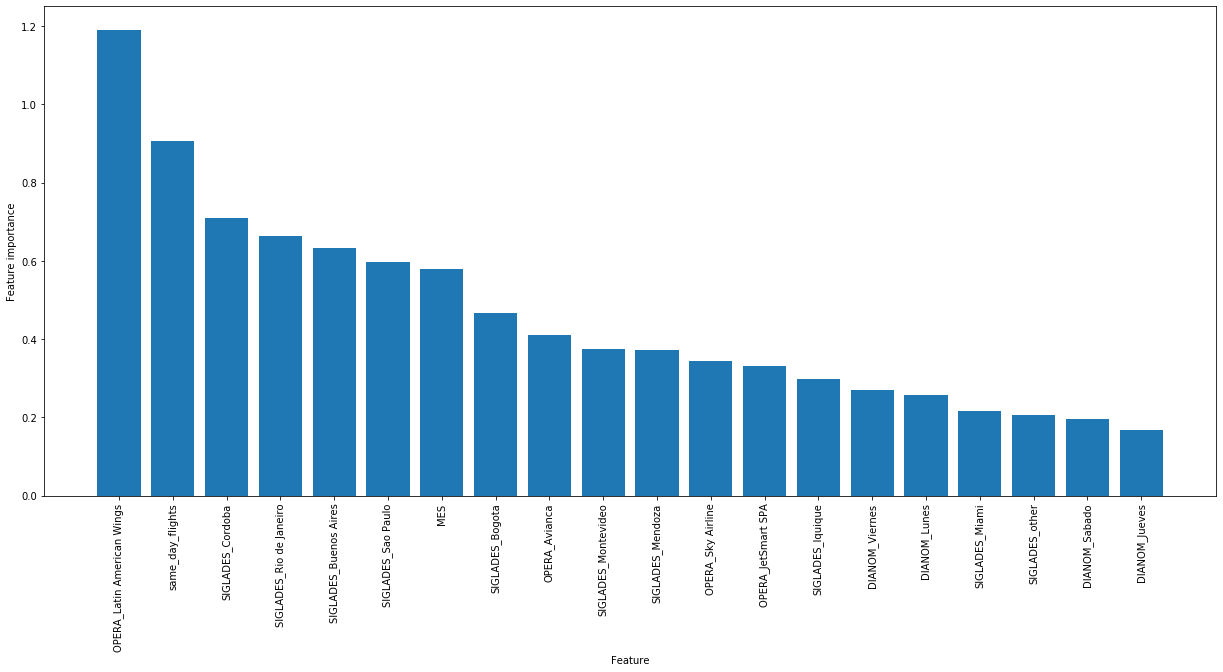

In [63]:
model = results['log_regression'].best_estimator_
coeff_df = pd.DataFrame(zip(mlmodel.feat_cols, np.transpose(model.coef_[0])), columns=['features', 'coeff'])
coeff_df = coeff_df.sort_values(by = ["coeff"], ascending=False).head(20)
plt.figure(figsize=(21,9))
plt.bar(coeff_df.features.values, coeff_df.coeff.values,label='Importance')
plt.ylabel('Feature importance')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.show()

5. Next steps to improve model: 

a. More historical data from more than one year. Currently it is just 2017.

b. Information like weather, percentage of seats occupied given the actual capacity of the flight and flag                to indicate if it was overbooked before take-off could helpful features. 

c. Advanced models like DNN or gradient boosting could be tried.

d. Reduce cardinality of certain columns through more optimized thresholds. Reducing cardinality can reduce overfitting and thus improving performance. 